# NOTES

### Task 1
Classify whether a loan will go into default or not

Should use 10-fold validation

Will use Neural Network, Ada Boosting, and SVM classifications

Need to include Visualizations - confusion matrices, bar chart of weighted factors, etc.

### Task 2
Use time series regression to predict monetary need for company in the next year

Use all but the final year of data as training to predict the final year as training model

Will use couple different types of ARMA, and maybe Vector Auto Regression (if in SAS)

Again need visualizations - confusion matrices, bar chart of weighted factors, etc.

#### Final Thoughts
Check the time to run each calculation via %timeit

Make sure to try various variables in each prediction model to get the best resuslts

See if there is a way to do stepwise or forward/backward search of features

To convert infinity to NAN, need to convert column to float and then can convert back as needed

# Mini Lab

## Brett Hallum, Mridul Jain, and Solomon Ndungu

We start this lab by filtering out our unwanted data. A lot of this information was removed in Lab 1 as it did not make sense for us to use it due to missing values, single values for whole set, and a minimal distribution of values. On top of this removal, we do some imputation to fill in minor missing data values. Finally, we do some nominal classification on some of our data to order it for better use.

We do create two additional data frames, loan_df_finished and loan_df_unfinished, at this point as well. Their purpose and usage will be discussed shortly.

In [1]:
# import os
# os.chdir('C:/Users/emrijai/Documents/IPython Notebooks/MS7331/Project1/MSDS7331_Project1')
# os.getcwd()

In [2]:
import pandas as pd
import numpy as np
import copy

import warnings
warnings.simplefilter('ignore', DeprecationWarning)
warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter("ignore")

#Bring in data set
loan_df = pd.read_csv('LoanData/loanData.csv')

#Remove unwanted attributes from the data set based on specific criteria
for col in ['id','funded_amnt_inv','sub_grade','emp_title','pymnt_plan','url','title','zip_code','earliest_cr_line',
            'mths_since_last_delinq','mths_since_last_record','pub_rec','revol_bal','revol_util',
            'initial_list_status','out_prncp_inv','total_pymnt_inv','recoveries','collection_recovery_fee',
            'last_pymnt_amnt','next_pymnt_d','last_credit_pull_d','collections_12_mths_ex_med','policy_code','application_type',
            'annual_inc_joint','dti_joint','verification_status_joint','open_acc_6m','open_il_6m','open_il_12m','open_il_24m',
            'mths_since_rcnt_il','total_bal_il','il_util','open_rv_12m','open_rv_24m','max_bal_bc','all_util',
            'total_rev_hi_lim','inq_fi','total_cu_tl','inq_last_12m', 'mths_since_last_major_derog', 'desc', 'addr_state', 'tot_coll_amt', 'tot_cur_bal', 'member_id', 'total_rec_prncp', 'total_rec_int',
           'total_rec_late_fee', 'loan_amnt', 'out_prncp']:
    if col in loan_df:
        del loan_df[col]

#Create new variables for classification
#Modify term to be integer for easier analysis
loan_df = loan_df.replace(to_replace=" 36 months", value=36)
loan_df = loan_df.replace(to_replace=" 60 months", value=60)

#Impute missing data values with median
for col in ['annual_inc', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'acc_now_delinq']:
    df_temp = copy.deepcopy(loan_df[col])
    df_temp = df_temp.replace(to_replace=np.nan, value=df_temp.median())
    loan_df[col] = df_temp
    
#Numerical classification of grade
tmp_df = pd.get_dummies(loan_df.grade,prefix='grade')
loan_df = pd.concat((loan_df,tmp_df),axis=1) # add back into the dataframe

if "grade" in loan_df:
    del loan_df["grade"]
    
#Numerical classification of employment length
tmp_df = pd.get_dummies(loan_df.emp_length,prefix='Employ')
loan_df = pd.concat((loan_df,tmp_df),axis=1) # add back into the dataframe

if "emp_length" in loan_df:
    del loan_df["emp_length"]

#Range of interest rates
loan_df['Int_Rate_Range'] = pd.cut(loan_df.int_rate, [0, 5,10,15,20,25, 30], 6, labels=[0, 1, 2, 3, 4, 5])

if "int_rate" in loan_df:
    del loan_df["int_rate"]

#Nominal classification of loan_status
loan_df.loc[loan_df['loan_status'] == 'Charged Off' , 'Loan_Class'] = 0
loan_df.loc[loan_df['loan_status'] == 'Default' , 'Loan_Class'] = 0
loan_df.loc[loan_df['loan_status'] == 'Late (31-120 days)' , 'Loan_Class'] = 0
loan_df.loc[loan_df['loan_status'] == 'Late (16-30 days)' , 'Loan_Class'] = 0
loan_df.loc[loan_df['loan_status'] == 'Does not meet the credit policy. Status:Charged Off' , 'Loan_Class'] = 0

loan_df.loc[loan_df['loan_status'] == 'Fully Paid' , 'Loan_Class'] = 1
loan_df.loc[loan_df['loan_status'] == 'Does not meet the credit policy. Status:Fully Paid' , 'Loan_Class'] = 1

loan_df.loc[loan_df['loan_status'] == 'Current' , 'Loan_Class'] = 1
loan_df.loc[loan_df['loan_status'] == 'In Grace Period' , 'Loan_Class'] = 1
loan_df.loc[loan_df['loan_status'] == 'Issued' , 'Loan_Class'] = 1

#Secondary classification of loan class for further analysis of data (used for new data frames)
# comparing the historical data (good/bad loans) to current data (loans still in progress)
# Loans are classified as 'Bad' if loans are bad
loan_df.loc[loan_df['loan_status'] == 'Charged Off' , 'Loan_Class2'] = 'Bad'
loan_df.loc[loan_df['loan_status'] == 'Default' , 'Loan_Class2'] = 'Bad'
loan_df.loc[loan_df['loan_status'] == 'Late (31-120 days)' , 'Loan_Class2'] = 'Bad'
loan_df.loc[loan_df['loan_status'] == 'Late (16-30 days)' , 'Loan_Class2'] = 'Bad'
loan_df.loc[loan_df['loan_status'] == 'Does not meet the credit policy. Status:Charged Off' , 'Loan_Class2'] = 'Bad'
# Loans are classified as 'Good' if loans are good
loan_df.loc[loan_df['loan_status'] == 'Fully Paid' , 'Loan_Class2'] = 'Good'
loan_df.loc[loan_df['loan_status'] == 'Does not meet the credit policy. Status:Fully Paid' , 'Loan_Class2'] = 'Good'
# Loans are classified as 'Current' if loans are current/still in progress
loan_df.loc[loan_df['loan_status'] == 'Current' , 'Loan_Class2'] = 'Current'
loan_df.loc[loan_df['loan_status'] == 'In Grace Period' , 'Loan_Class2'] = 'Current'
loan_df.loc[loan_df['loan_status'] == 'Issued' , 'Loan_Class2'] = 'Current'

if "loan_status" in loan_df:
    del loan_df["loan_status"]

#Nominal classification of verification status
loan_df.loc[loan_df['verification_status'] == 'Verified', 'Verify_Status'] = 1
loan_df.loc[loan_df['verification_status'] == 'Source Verified', 'Verify_Status'] = 1
loan_df.loc[loan_df['verification_status'] == 'Not Verified', 'Verify_Status'] = 0

if "verification_status" in loan_df:
    del loan_df["verification_status"]

#Nominal classification of home ownership
tmp_df = pd.get_dummies(loan_df.home_ownership,prefix='Home')
loan_df = pd.concat((loan_df,tmp_df),axis=1) # add back into the dataframe

if "home_ownership" in loan_df:
    del loan_df["home_ownership"]

#Impute missing data values with median
for col in ['total_acc']:
    df_temp = copy.deepcopy(loan_df[col])
    df_temp = df_temp.replace(to_replace=np.nan, value= 0 )
    loan_df[col] = df_temp    

for col in ['total_pymnt']:
    df_temp = copy.deepcopy(loan_df[col])
    df_temp = df_temp.replace(to_replace=np.nan, value= 0 )
    loan_df[col] = df_temp 
   

tmp_df = pd.get_dummies(loan_df.purpose,prefix='Loan_Purpose')
loan_df = pd.concat((loan_df,tmp_df),axis=1)

if 'purpose' in loan_df:
    del loan_df['purpose']
    
loan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887379 entries, 0 to 887378
Data columns (total 56 columns):
funded_amnt                        887379 non-null int64
term                               887379 non-null int64
installment                        887379 non-null float64
annual_inc                         887379 non-null float64
issue_d                            887379 non-null object
dti                                887379 non-null float64
delinq_2yrs                        887379 non-null float64
inq_last_6mths                     887379 non-null float64
open_acc                           887379 non-null float64
total_acc                          887379 non-null float64
total_pymnt                        887379 non-null float64
last_pymnt_d                       869720 non-null object
acc_now_delinq                     887379 non-null float64
grade_A                            887379 non-null float64
grade_B                            887379 non-null float64
grade_C   

In [3]:
loan_df = loan_df.dropna()
print loan_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 869720 entries, 0 to 887378
Data columns (total 56 columns):
funded_amnt                        869720 non-null int64
term                               869720 non-null int64
installment                        869720 non-null float64
annual_inc                         869720 non-null float64
issue_d                            869720 non-null object
dti                                869720 non-null float64
delinq_2yrs                        869720 non-null float64
inq_last_6mths                     869720 non-null float64
open_acc                           869720 non-null float64
total_acc                          869720 non-null float64
total_pymnt                        869720 non-null float64
last_pymnt_d                       869720 non-null object
acc_now_delinq                     869720 non-null float64
grade_A                            869720 non-null float64
grade_B                            869720 non-null float64
grade_C   

In [4]:
from datetime import datetime
loan_df['duration_paid'] =  (pd.to_datetime(loan_df['last_pymnt_d']) - pd.to_datetime(loan_df['issue_d']))

In [5]:
loan_df['Count_Days'] =  loan_df['duration_paid'].dt.days
loan_df['Payment_rate'] =  loan_df['total_pymnt'] / (loan_df['Count_Days']+1)*30
loan_df['Payment_ratio'] = loan_df['Payment_rate']/ loan_df['installment']

In [6]:
loan_df = loan_df.dropna()

In [7]:
if "issue_d" in loan_df:
    del loan_df["issue_d"]
if "last_pymnt_d" in loan_df:
    del loan_df["last_pymnt_d"]
if "total_pymnt" in loan_df:
    del loan_df["total_pymnt"]
if "duration_paid" in loan_df:
    del loan_df["duration_paid"]
if "Count_Days" in loan_df:
    del loan_df['Count_Days']

In [8]:
# Create separate data frames for future analysis and breakdown
loan_df_unfinished = loan_df[loan_df['Loan_Class2'] == 'Current'] #Data of uncompleted loans
loan_df_finished = loan_df[(loan_df['Loan_Class2'] == 'Bad') | (loan_df['Loan_Class2']=='Good')] #Data of completed loans

#loan_df.copy()

if "Loan_Class2" in loan_df:
    del loan_df["Loan_Class2"]

In [9]:
loan_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 869720 entries, 0 to 887378
Data columns (total 54 columns):
funded_amnt                        869720 non-null int64
term                               869720 non-null int64
installment                        869720 non-null float64
annual_inc                         869720 non-null float64
dti                                869720 non-null float64
delinq_2yrs                        869720 non-null float64
inq_last_6mths                     869720 non-null float64
open_acc                           869720 non-null float64
total_acc                          869720 non-null float64
acc_now_delinq                     869720 non-null float64
grade_A                            869720 non-null float64
grade_B                            869720 non-null float64
grade_C                            869720 non-null float64
grade_D                            869720 non-null float64
grade_E                            869720 non-null float64
grade_F 

In [10]:
from sklearn.cross_validation import ShuffleSplit, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier

from matplotlib import pyplot as plt


# Split our data frame into our classification of Loan_Class and the rest of the data set
if 'Loan_Class' in loan_df:
    y = loan_df['Loan_Class'].values
    del loan_df['Loan_Class']
    X = loan_df.values

In [11]:
# Create data frame for set of finished loans
# Add column to determine if loan is good or bad based on classification in data set
loan_df_finished['isGoodLoan'] = loan_df_finished['Loan_Class2'] == 'Good'
loan_df_finished.isGoodLoan = loan_df_finished.isGoodLoan.astype(np.int)

#Remove Loan_Class and Loan_Class2 from the data frame so they are no longer observed for classification
if "Loan_Class" in loan_df_finished:
    del loan_df_finished["Loan_Class"]
if "Loan_Class2" in loan_df_finished:
    del loan_df_finished["Loan_Class2"]
    
# Split the data into our x and y matrices for testing
if 'isGoodLoan' in loan_df_finished:
    updated_y = loan_df_finished['isGoodLoan'].values
    del loan_df_finished['isGoodLoan']
    updated_X = loan_df_finished.values

## Classification of Whether or Not a Loan is Expected to Default

In continuing research from the Mini-Lab, we want to see if we can successfully classify the loan owners that we think will go into default. We will use a Random Forest Model, an Ada-Boosted Model, and an SVM Model to see which of these classifies these correctly and efficiently.

We use 10-fold classification on our training data, the finished loans, to get a sufficient model using each of our classification models. This should resolve any outliers that may be present in the set since each point gets to be trained against 9 times and tested against once. Finally, for some cross-validation, we will use the decided model on the unfinished loans to see the predicted number of defaulted loans that should occur.

For a bank to consider any of these classifications successful, they would want the data to be "over" classified to a slight extent. By giving a banking company a list of members that we think will default, they can attempt to work with those members more closely to try and prevent the default from happening. This should see the bank make money on the loans, from the interest, instead of losing out completely through default. If there is some over classification and there are a few members that are thought to be going into default that aren't, approaching them would not hurt the business too much and it is better to contact them if there is a risk of it happening even if it is not likely. There would be a cost associated with reaching out to these members however, so ensuring there is not a severe over classification is key.

### Random Forest Classification

We will begin looking at our classifications by observing how well the Random Forest can classify the data set.

In [12]:
from sklearn.ensemble import RandomForestClassifier

# Create iterator for cross validation
cv = StratifiedKFold(updated_y, n_folds=10)

# Obj for RandomForestClassifier to pass features
randomforest_obj = RandomForestClassifier(n_estimators=10, max_depth=None,
                                         max_features="auto", oob_score=True)

#Holder for predictions of each cv
y_hat = np.zeros(updated_y.shape)

# Fit and test the regression model for each shuffled instance
for iter_num, (train_indices, test_indices) in enumerate(cv):
    randomforest_obj.fit(updated_X[train_indices],updated_y[train_indices])  # train object
    y_hat[test_indices] = randomforest_obj.predict(updated_X[test_indices]) # get test set precitions

# print the accuracy and confusion matrix 
print "total accuracy", mt.accuracy_score(updated_y,y_hat) 
print "confusion matrix\n",mt.confusion_matrix(updated_y,y_hat)

total accuracy 0.87376470327
confusion matrix
[[ 42743  17724]
 [ 16382 193329]]


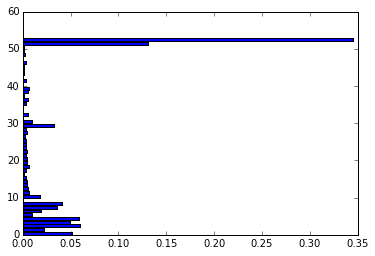

Generalization score estimate from training data 0.850185679447


In [13]:
%matplotlib inline

plt.barh(range(len(randomforest_obj.feature_importances_)), randomforest_obj.feature_importances_)
plt.show()

print 'Generalization score estimate from training data', randomforest_obj.oob_score_

In [14]:
for val in ['gini', 'entropy']:
    print('============== Random Forest with '+ val + ' criterion ===========')
    
    for n_est in range(1, 6):
        print ('------ N-Estimator set to '+ str(n_est * 10) +' ------')
        
        for max_depth in range(4,7):
            print ('++++++ Max-Depth set to '+ str(max_depth * 5) + '++++++')
            # Obj for RandomForestClassifier to pass features
            randomforest_obj = RandomForestClassifier(n_estimators=(n_est*10), max_depth=(max_depth*5),
                                                 max_features="auto", oob_score=True, criterion=val)

            #Holder for predictions of each cv
            y_hat = np.zeros(updated_y.shape)

            # Fit and test the regression model for each shuffled instance
            for iter_num, (train_indices, test_indices) in enumerate(cv):
                randomforest_obj.fit(updated_X[train_indices],updated_y[train_indices])  # train object
                y_hat[test_indices] = randomforest_obj.predict(updated_X[test_indices]) # get test set precitions

            # print the accuracy and confusion matrix 
            print "total accuracy", mt.accuracy_score(updated_y,y_hat) 
            print "confusion matrix\n",mt.confusion_matrix(updated_y,y_hat)
            print "Recall score", mt.recall_score(updated_y,y_hat)
            print "Precision score", mt.precision_score(updated_y,y_hat)

============== Random Forest with gini criterion ===========
------ N-Estimator set to 10 ------
++++++ Max-Depth set to 20++++++
total accuracy 0.881033985002
confusion matrix
[[ 39612  20855]
 [ 11287 198424]]
Recall score 0.946178312058
Precision score 0.904892853397
++++++ Max-Depth set to 25++++++
total accuracy 0.879968021082
confusion matrix
[[ 40746  19721]
 [ 12709 197002]]
Recall score 0.939397551869
Precision score 0.909003659049
++++++ Max-Depth set to 30++++++
total accuracy 0.876932984921
confusion matrix
[[ 41815  18652]
 [ 14598 195113]]
Recall score 0.930389917553
Precision score 0.912745304423
------ N-Estimator set to 20 ------
++++++ Max-Depth set to 20++++++
total accuracy 0.883425001295
confusion matrix
[[ 39888  20579]
 [ 10917 198794]]
Recall score 0.947942644878
Precision score 0.906191737361
++++++ Max-Depth set to 25++++++
total accuracy 0.884165254018
confusion matrix
[[ 40551  19916]
 [ 11380 198331]]
Recall score 0.94573484462
Precision score 0.90874559558

### AdaBoosting - Classification with Decision Trees

E:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
E:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
E:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


AdaBoost: 0.829194270698


E:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
E:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
E:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


AdaBoost: 0.863535420831


E:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
E:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
E:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


AdaBoost: 0.904434080983


E:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
E:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
E:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


AdaBoost: 0.890850544082


E:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
E:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
E:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


AdaBoost: 0.838070915686


E:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
E:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
E:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


AdaBoost: 0.887149307869


E:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
E:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
E:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


AdaBoost: 0.918202679695


E:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
E:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
E:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


AdaBoost: 0.925454343561


E:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
E:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
E:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


AdaBoost: 0.950808750046


E:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
E:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
E:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


AdaBoost: 0.971536440019


<function matplotlib.pyplot.show>

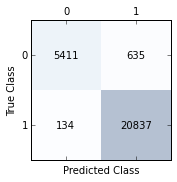

In [16]:
warnings.simplefilter("ignore")

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_gaussian_quantiles
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

clf_ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=4), algorithm="SAMME", n_estimators=50)

scl = StandardScaler()
for train_idx, test_idx in cv:
    clf_ada.fit(scl.fit_transform(updated_X[train_idx]),updated_y[train_idx])
    yhat = clf_ada.predict(scl.transform(updated_X[test_idx]))
        
    conf = mt.confusion_matrix(updated_y[test_idx],yhat)
    acc = mt.accuracy_score(updated_y[test_idx],yhat)

    print 'AdaBoost:', acc
    print "Recall:", mt.recall_score(updated_y,y_hat)
    print "Precision:", mt.precision_score(updated_y,y_hat)

fig, ax = plt.subplots(figsize=(2.5,2.5))
ax.matshow(conf, cmap=plt.cm.Blues, alpha = 0.3)
for i in range (conf.shape[0]):
    for j in range (conf.shape[1]):
        ax.text(x=j, y=i, s=conf[i, j], va = 'center', ha = 'center')
plt.xlabel ('Predicted Class')
plt.ylabel ('True Class')
plt.show

### AdaBoosting - Classification with weak learner like Random Forest

AdaBoost: 0.811391983419
AdaBoost: 0.823821156266
AdaBoost: 0.886261011178
AdaBoost: 0.88178251536
AdaBoost: 0.824820490044
AdaBoost: 0.870382707824
AdaBoost: 0.914094307499
AdaBoost: 0.916682089055
AdaBoost: 0.927601140023
AdaBoost: 0.96324536403


<function matplotlib.pyplot.show>

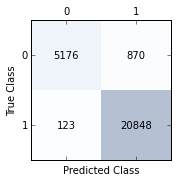

In [18]:
warnings.simplefilter("ignore")

from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=10, random_state=0)
clf_ada = AdaBoostClassifier(RandomForestClassifier(n_estimators=5, random_state=0), algorithm="SAMME", n_estimators=50)

scl = StandardScaler()
for train_idx, test_idx in cv:
    clf_ada.fit(scl.fit_transform(updated_X[train_idx]),updated_y[train_idx])
    yhat = clf_ada.predict(scl.transform(updated_X[test_idx]))
        
    conf = mt.confusion_matrix(updated_y[test_idx],yhat)
    acc = mt.accuracy_score(updated_y[test_idx],yhat)

    print 'AdaBoost:', acc
    print "Recall:", mt.recall_score(updated_y,y_hat)
    print "Precision:", mt.precision_score(updated_y,y_hat)

fig, ax = plt.subplots(figsize=(2.5,2.5))
ax.matshow(conf, cmap=plt.cm.Blues, alpha = 0.3)
for i in range (conf.shape[0]):
    for j in range (conf.shape[1]):
        ax.text(x=j, y=i, s=conf[i, j], va = 'center', ha = 'center')
plt.xlabel ('Predicted Class')
plt.ylabel ('True Class')
plt.show

### Support Vector Machines

We continue our trials by observing the Support Vector Machines (SVM) to see if this method of classification can classify our data set better than logistic regression. We will start by observing the SVM of our original data set. Although it will most likely turn out the same way, not giving very good data, the SVM may reveal new splits in the decision. We will follow that up with looking at the SVM of the reduced data set that contains the completed loans. We can compare the accuracy of the SVM with the above logistic regression to determine if one classifies this data better than the other.

Note: We use the SGDClassifier due to the size of our data set. Both sets are large and would take too long to train with a normal SVM in a time that is reasonable.

In [ ]:
# SGDClassifier using 'hinge' for loss to get an SVM
from sklearn.linear_model import SGDClassifier

regularize_const = 0.1
iterations = 5
svm_sgd = SGDClassifier(alpha=regularize_const,
        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
        loss='hinge', n_iter=iterations, n_jobs=-1, penalty='l2')

scl = StandardScaler()
for train_idx, test_idx in updated_cv_obj:
    svm_sgd.fit(scl.fit_transform(updated_X[train_idx]),updated_y[train_idx])
    yhat = svm_sgd.predict(scl.transform(updated_X[test_idx]))
    
    conf = mt.confusion_matrix(updated_y[test_idx],yhat)
    acc = mt.accuracy_score(updated_y[test_idx],yhat)

    print 'SVM:', acc
    print 'Confusion Matrix:\n', conf
    print 'Coefficients', svm_sgd.coef_
    
weights = pd.Series(svm_sgd.coef_[0],index=loan_df_finished.columns)
weights.plot(kind='bar', figsize=(16,4))

The SVM for the reduced data, which includes just completed loans, has a much lower accuracy than the logistic regression classification of the same data. The accuracy dropped from just below 98.0% to around 86.8%. This is a significant difference. It is possible that part of this is due to SGDClassifier taking the Stochastic Gradient instead of the full gradient of the SVM. Although the SGD runs faster than the linear regression model we used (LinearRegression()), it does not have the accuracy that we would expect or want in this situation, especially when the original data stayed around the same accuracy between the two different classifications.

It is interesting to note that the classes that the SVM pulls out are almost identical to the ones the logistic regression uses. Funded amount and total payment are still at the top of the list with Interest Rate Range being a distant fourth, but still near the top. Surprisingly, it has added importance on the 'Term' variable that the logistic regression did not pull out.

In [ ]:
# Changing SVM Model Parameters - can alter penalty, L1 ratio and alpha

for val in range(6):
    print "======= L1 Penalty with alpha =", 10**(-val), "========"
    regularize_const = 10**(-val)
    iterations = 6
    svm_sgd = SGDClassifier(alpha=regularize_const,
            fit_intercept=True, l1_ratio=1, learning_rate='optimal',
            loss='hinge', n_iter=iterations, n_jobs=-1, penalty='L1')

    scl = StandardScaler()
    for train_idx, test_idx in updated_cv_obj:
        svm_sgd.fit(scl.fit_transform(updated_X[train_idx]),updated_y[train_idx])
        yhat = svm_sgd.predict(scl.transform(updated_X[test_idx]))

        conf = mt.confusion_matrix(updated_y[test_idx],yhat)
        acc = mt.accuracy_score(updated_y[test_idx],yhat)

    print 'SVM:', acc
    print 'Confusion Matrix:\n', conf
    
for val in range(6):
    print "======= L1 Penalty with l1_ratio =", (val/4.0), "========"
    regularize_const = 0.0001
    iterations = 6
    svm_sgd = SGDClassifier(alpha=regularize_const,
            fit_intercept=True, l1_ratio=val/4, learning_rate='optimal',
            loss='hinge', n_iter=iterations, n_jobs=-1, penalty='L1')

    scl = StandardScaler()
    for train_idx, test_idx in updated_cv_obj:
        svm_sgd.fit(scl.fit_transform(updated_X[train_idx]),updated_y[train_idx])
        yhat = svm_sgd.predict(scl.transform(updated_X[test_idx]))

        conf = mt.confusion_matrix(updated_y[test_idx],yhat)
        acc = mt.accuracy_score(updated_y[test_idx],yhat)

    print 'SVM:', acc
    print 'Confusion Matrix:\n', conf
    
for val in range(6):
    print "======= L2 Penalty with alpha =", 10**(-val), "========"
    regularize_const = 10**(-val)
    iterations = 6
    svm_sgd = SGDClassifier(alpha=regularize_const,
            fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
            loss='hinge', n_iter=iterations, n_jobs=-1, penalty='L2')

    scl = StandardScaler()
    for train_idx, test_idx in updated_cv_obj:
        svm_sgd.fit(scl.fit_transform(updated_X[train_idx]),updated_y[train_idx])
        yhat = svm_sgd.predict(scl.transform(updated_X[test_idx]))

        conf = mt.confusion_matrix(updated_y[test_idx],yhat)
        acc = mt.accuracy_score(updated_y[test_idx],yhat)

    print 'SVM:', acc
    print 'Confusion Matrix:\n', conf

## Time Series Regression to Forecast Needed Funding

We will now use timeseries forecasting and regression models to forecast the amount of funding needed by "Lending Club" over the next few years.

In [6]:
import pandas as pd
import numpy as np
import copy

%matplotlib inline
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter('ignore', DeprecationWarning)
warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter("ignore")

import datetime
from dateutil.relativedelta import relativedelta
import seaborn as sns
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA

As we can see from the Loan Amount, the company has clearly been providing more loans in the past few years. Even though the cash from interest and installments is coming in, it might not be enough to fund the future needs of the company. In order to predict how much money the company will need in the next few months, it is important to plan accordingly. 

These steps are taken below to analyze the future funding needs by "Lending Tree" to continue growing and distributing loans at their current growth rate.

1. Visualize the trends
2. Check for Non-Stationarity, and statirnarize the series data
3. Check the ACF/PACF charts to find the optimal parameters
4. Build appropriate Model (ARIMA/ARMA)
5. Forecast the amount of money required in next 100 Weeks

A modified data set is brought in that is consolidated from the original set. This modified set contains a monthly count of all the variables including a funding amount cummulative up to the month, a monthly funded amount, the total payments receieved and total of payments received per month.

In [3]:
#Bring in data set
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
loan_df = pd.read_csv('LoanData/Funded_Amount_Sum.csv', parse_dates='Month', index_col='Month',date_parser=dateparse)
loan_df = loan_df.dropna()
print loan_df.info()
print loan_df.head()

import calendar
pd.options.mode.chained_assignment = None

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 103 entries, 2007-06-01 to 2015-12-01
Data columns (total 5 columns):
Funded_Amnt_Cum          103 non-null int64
Funded_Amnt_Monthly      103 non-null int64
Total_Rec_Payment        103 non-null int64
Total_Payment_Monthly    103 non-null int64
Difference_Amount        103 non-null int64
dtypes: int64(5)
memory usage: 4.8 KB
None
            Funded_Amnt_Cum  Funded_Amnt_Monthly  Total_Rec_Payment  \
Month                                                                 
2007-06-01            91850                91850             103711   
2007-07-01           423950               332100             452870   
2007-08-01           912550               488600             940349   
2007-09-01          1285500               372950            1318937   
2007-10-01          1968375               682875            1984635   

            Total_Payment_Monthly  Difference_Amount  
Month                                                 
2007-0

In [4]:
print (loan_df.index)
loan_df_shape_old = loan_df.shape[0]

DatetimeIndex(['2007-06-01', '2007-07-01', '2007-08-01', '2007-09-01',
               '2007-10-01', '2007-11-01', '2007-12-01', '2008-01-01',
               '2008-02-01', '2008-03-01',
               ...
               '2015-03-01', '2015-04-01', '2015-05-01', '2015-06-01',
               '2015-07-01', '2015-08-01', '2015-09-01', '2015-10-01',
               '2015-11-01', '2015-12-01'],
              dtype='datetime64[ns]', name=u'Month', length=103, freq=None)


The monthly amount funded by the company is shown below (prior to 2011, the funding was very small, but it has picked up in recent months)

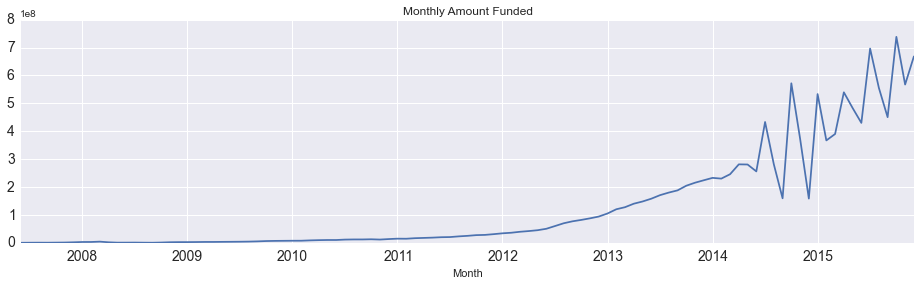

In [7]:
loan_df['Funded_Amnt_Monthly'].plot(figsize=(16,4), title= 'Monthly Amount Funded', fontsize=14)
plt.savefig('Monthly_Loaned_Amount.png', bbox_inches='tight')

The below images show that the amount of incoming funds from interest payments and total payments has reduced considerably in the past few months, especially during the end of 2015. If the data is correct, then this is an alarming sign for the company. If the company keeps distributing loans at this rate, there will be a lot of issues looming in the near future. 

In recent months, differences between received money vs loaned money has increased quickly. There are close to $6B USD that is currently issues to borrowers, but with a considerablly reduced inflow of funds.

In summary:
1. 12B USD total loans have been issued so far
2. ~6.2B USD are currently issued as loans 
3. ~6.5B USD payments collected
4. The payments collection slope flattened and clearly the amount of money coming in has reduced considerably

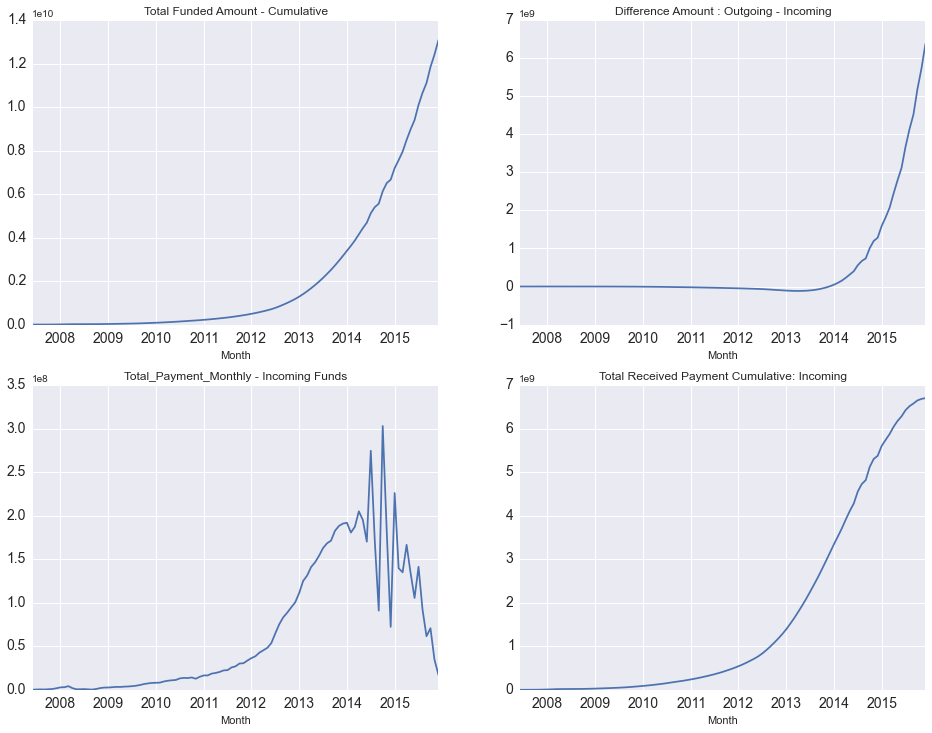

In [8]:
from matplotlib.pyplot import *
fig = plt.figure(figsize=(16,12))

subplot (2,2,1)
loan_df['Funded_Amnt_Cum'].plot(title= 'Total Funded Amount - Cumulative', fontsize=14)


subplot (2,2,2)
loan_df['Difference_Amount'].plot( title= 'Difference Amount : Outgoing - Incoming', fontsize=14)


subplot (2,2,3)
loan_df['Total_Payment_Monthly'].plot( title= 'Total_Payment_Monthly - Incoming Funds', fontsize=14)


subplot (2,2,4)
loan_df['Total_Rec_Payment'].plot( title= 'Total Received Payment Cumulative: Incoming', fontsize=14)


As we visualize the the above plots, we can see there is both an upward exponential trend in the funded amount data and there seems to be some seasonality to when payments are made.

Because of this seasonality fluctuation, we visualize the data with a seasonal_decompose function in statsmodel. The seasonal trend becomes even more obvious.

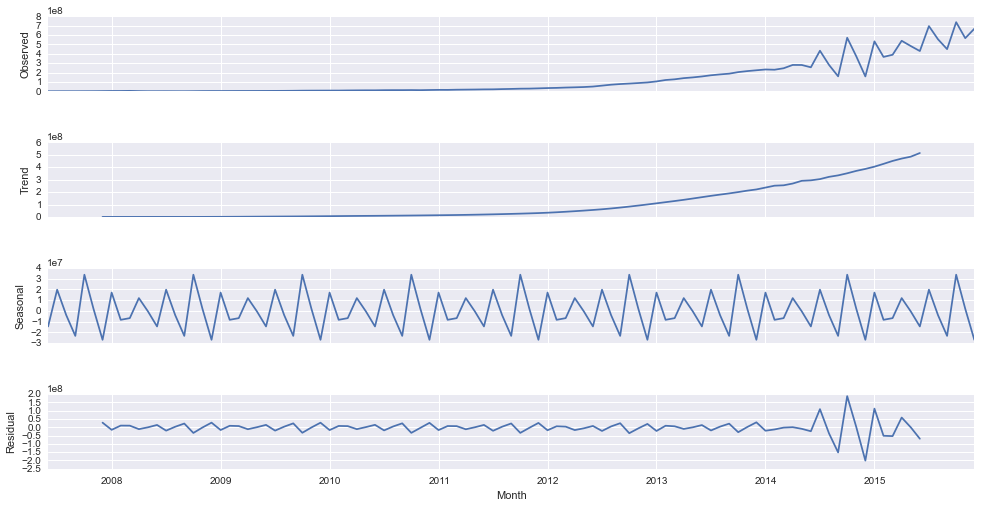

In [9]:
decomposition = seasonal_decompose(loan_df['Funded_Amnt_Monthly'], freq=12)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

Most of the timeseries (TS) models work on the assumption that the TS is stationary. Intuitively, we can say that if a TS has a particular behaviour over time, there is a very high probability that it will follow the same behviour in the future.

A TS is said to be stationary if its statistical properties such as mean and variance remain constant over time. For a more accurate assessment we run the Dickey-Fuller test from statsmodels package. This is one of the statistical tests to check for stationarity. Here, the null hypothesis is that the TS is non-stationary. The test results comprise of a test statistic and the critical values for different confidence levels. If the test statistic is less than the critical value, we can reject the null hypothesis and say that the series is stationary. 

In [17]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    fig = plt.figure(figsize=(16, 4))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

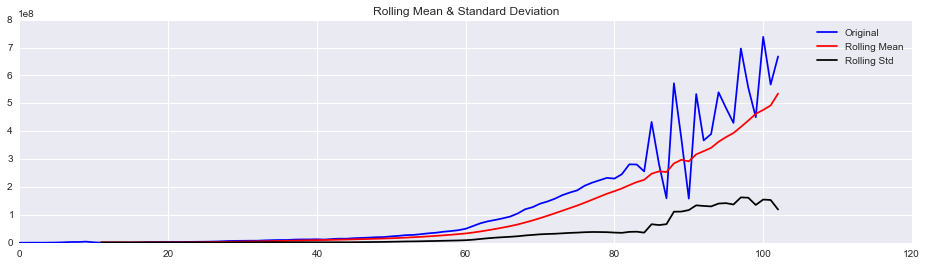

Results of Dickey-Fuller Test:
Test Statistic                  2.262782
p-value                         0.998930
#Lags Used                     12.000000
Number of Observations Used    90.000000
Critical Value (5%)            -2.894232
Critical Value (1%)            -3.505190
Critical Value (10%)           -2.584210
dtype: float64


In [18]:
test_stationarity(loan_df['Funded_Amnt_Monthly'])

Clearly, the variation in standard deviation is large during the last few months. The mean is clearly increasing with time. The test statistic is significantly larger than the critical values. This tells us that the time series is not stationary and the test_stationarity function confirms that.

In order to further analyze the data, we have to make the series behave in a Stationarity manner. In general, there are two components to do this.

1. Trend – varying mean over time. For example, in this case we saw that on average, the number of loans was growing over time
2. Seasonality - variations at specific time-frames. eg people might have a tendency to bowwor more in a particular month because of seasonal issues or festivals

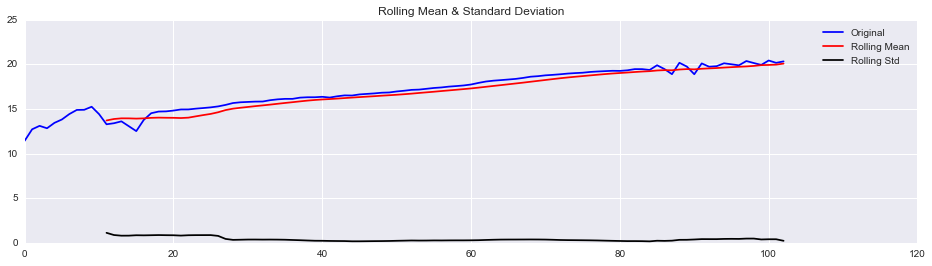

Results of Dickey-Fuller Test:
Test Statistic                 -2.201031
p-value                         0.205871
#Lags Used                     13.000000
Number of Observations Used    89.000000
Critical Value (5%)            -2.894607
Critical Value (1%)            -3.506057
Critical Value (10%)           -2.584410
dtype: float64


In [23]:
#Log Transform of dataset
loan_df['Funded_Amnt_Monthly_log']= loan_df['Funded_Amnt_Monthly'].apply(lambda x: np.log(x))  
test_stationarity(loan_df['Funded_Amnt_Monthly_log'])

A Log Transformation of the series helped, but the series is still not stationary. We can do first differencing, and then first log differencing to bring the series to stationarity.

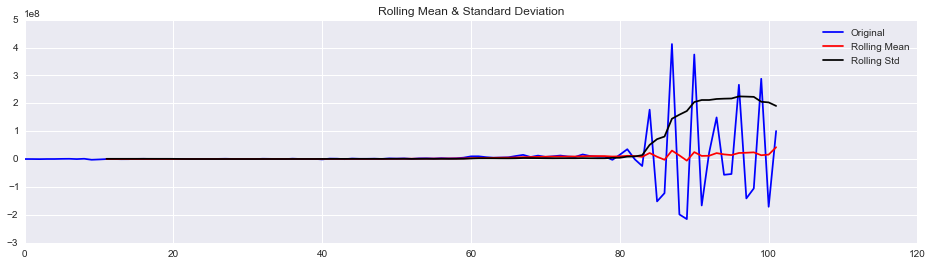

Results of Dickey-Fuller Test:
Test Statistic                  3.678051
p-value                         1.000000
#Lags Used                     13.000000
Number of Observations Used    88.000000
Critical Value (5%)            -2.894990
Critical Value (1%)            -3.506944
Critical Value (10%)           -2.584615
dtype: float64


In [22]:
#First Differencing of dataset
loan_df['Funded_Amnt_Monthly_1stDiff'] = loan_df['Funded_Amnt_Monthly'] - loan_df['Funded_Amnt_Monthly'].shift(1)  
test_stationarity(loan_df['Funded_Amnt_Monthly_1stDiff'].dropna(inplace=False))

As we note above, the first differencing did not yield stationarity to the data.

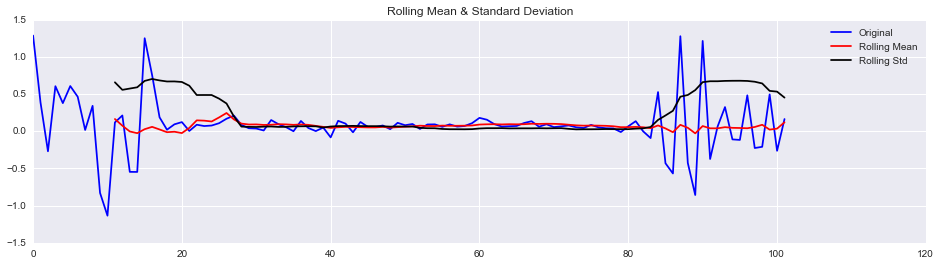

Results of Dickey-Fuller Test:
Test Statistic                 -4.550885
p-value                         0.000159
#Lags Used                     13.000000
Number of Observations Used    88.000000
Critical Value (5%)            -2.894990
Critical Value (1%)            -3.506944
Critical Value (10%)           -2.584615
dtype: float64


In [24]:
#First differencing by log of the series
loan_df['Funded_Amnt_Monthly_log_1stDiff'] = loan_df['Funded_Amnt_Monthly_log'] - loan_df['Funded_Amnt_Monthly_log'].shift(1)  
test_stationarity(loan_df['Funded_Amnt_Monthly_log_1stDiff'].dropna(inplace=False))

We can now see by the p-value that the first difference of the log of the data has made our data stationary. We also looked at doing double log, double differencing etc, but it didn’t make the data any more stationary

The next step is to determine the tuning parameters of the model. This is achieved by looking at the autocorrelation and partial autocorrelation graphs for 2nd order differencing and 3rd order differencing or the log transformed timeseries.

Rules reference: http://people.duke.edu/~rnau/arimrule.htm

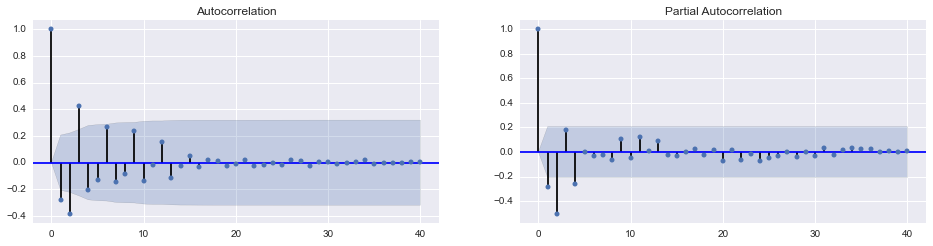

In [25]:
fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(221)
fig = sm.graphics.tsa.plot_acf(loan_df['Funded_Amnt_Monthly_log_1stDiff'].iloc[13:], lags=40, ax=ax1)
ax2 = fig.add_subplot(222)
fig = sm.graphics.tsa.plot_pacf(loan_df['Funded_Amnt_Monthly_log_1stDiff'].iloc[13:], lags=40, ax=ax2)

Some rules to follow:

Rule 1: If the partial autocorrelation function (PACF) of the differenced series displays a sharp cutoff and/or the lag-1 autocorrelation is positive--i.e., if the series appears slightly "underdifferenced"--then consider adding one or more AR terms to the model. The lag beyond which the PACF cuts off is the indicated number of AR terms.

Rule 2: If the autocorrelation function (ACF) of the differenced series displays a sharp cutoff and/or the lag-1 autocorrelation is negative--i.e., if the series appears slightly "overdifferenced"--then consider adding an MA term to the model. The lag beyond which the ACF cuts off is the indicated number of MA terms.


In this case, we have a PACF that goes negative. We check different AR/MA values. The values of AR for p = 0 seem sufficient, but with ACF the lag-1 autocorrelation is negative. Hence, q = 2 seems to be a good choice for the correlation, and we already know that we should take single differencing i.e. d= 1.

In [26]:
loan_df['Funded_Amnt_Monthly_log_1stDiff'] = loan_df['Funded_Amnt_Monthly_log_1stDiff'].fillna(0)

The model with single order differencing is performs better with p=0 and q=2

In [27]:
mod = sm.tsa.ARIMA(loan_df['Funded_Amnt_Monthly'].apply(lambda x: np.log(x)), order=(0,1,2))
results_AR = mod.fit()
print results_AR.summary()

                               ARIMA Model Results                               
Dep. Variable:     D.Funded_Amnt_Monthly   No. Observations:                  102
Model:                    ARIMA(0, 1, 2)   Log Likelihood                 -32.429
Method:                          css-mle   S.D. of innovations              0.331
Date:                   Thu, 14 Jul 2016   AIC                             72.857
Time:                           16:53:31   BIC                             83.357
Sample:                       07-01-2007   HQIC                            77.109
                            - 12-01-2015                                         
                                  coef    std err          z      P>|z|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------------
const                           0.0810      0.021      3.885      0.000         0.040     0.122
ma.L1.D.Funded_Amnt_Monthly     0.1530      0.106      1

Below we compare other models with varying values of p, d, and q. In all cases, there is not much difference in the RMSE and the Model Statistics. We choose to us the model with the least RMSE, i.e. (p,d,q) = (0,1,2)

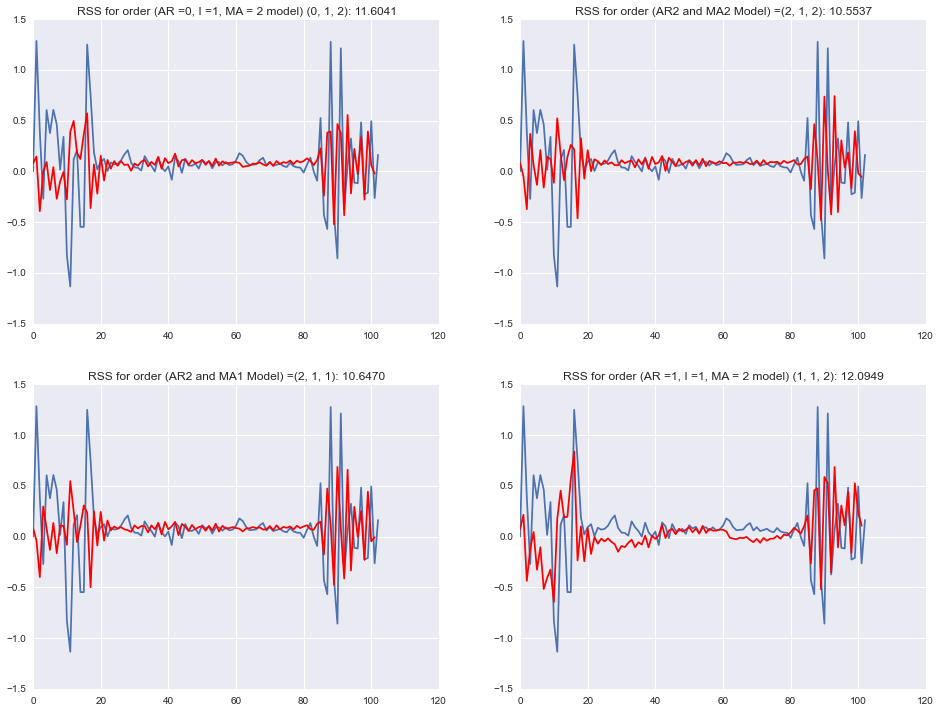

In [28]:
from matplotlib.pyplot import *
fig = plt.figure(figsize=(16,12))

subplot(221)
model = ARIMA(loan_df['Funded_Amnt_Monthly'].apply(lambda x: np.log(x)), order=(0, 1, 2))
results_AR = model.fit(disp=-1)  
plt.plot(loan_df['Funded_Amnt_Monthly_log_1stDiff'])
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS for order (AR =0, I =1, MA = 2 model) (0, 1, 2): %.4f'% sum((results_AR.fittedvalues-loan_df['Funded_Amnt_Monthly_log_1stDiff'][1:])**2))

subplot(222)
model = ARIMA(loan_df['Funded_Amnt_Monthly'].apply(lambda x: np.log(x)), order=(2, 1, 2))
results_AR = model.fit(disp=-1)  
plt.plot(loan_df['Funded_Amnt_Monthly_log_1stDiff'])
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS for order (AR2 and MA2 Model) =(2, 1, 2): %.4f'% sum((results_AR.fittedvalues-loan_df['Funded_Amnt_Monthly_log_1stDiff'][1:])**2))

subplot(223)
model = ARIMA(loan_df['Funded_Amnt_Monthly'].apply(lambda x: np.log(x)), order=(2, 1, 1))
results_AR = model.fit(disp=-1)  
plt.plot(loan_df['Funded_Amnt_Monthly_log_1stDiff'])
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS for order (AR2 and MA1 Model) =(2, 1, 1): %.4f'% sum((results_AR.fittedvalues-loan_df['Funded_Amnt_Monthly_log_1stDiff'][1:])**2))


subplot(224)
model = ARIMA(loan_df['Funded_Amnt_Monthly'].apply(lambda x: np.log(x)), order=(1, 1, 2))
results_AR = model.fit(disp=-1)  
plt.plot(loan_df['Funded_Amnt_Monthly_log_1stDiff'])
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS for order (AR =1, I =1, MA = 2 model) (1, 1, 2): %.4f'% sum((results_AR.fittedvalues-loan_df['Funded_Amnt_Monthly_log_1stDiff'][1:])**2))



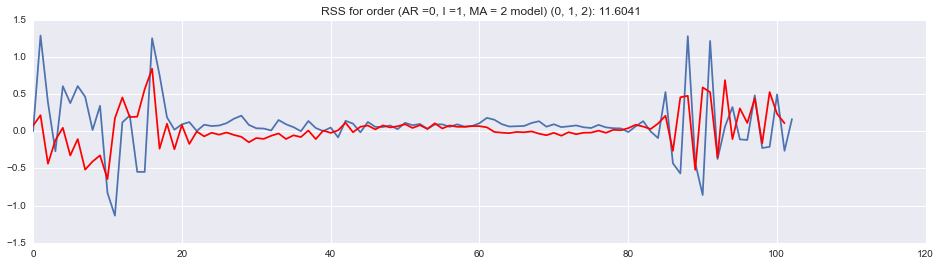

In [29]:
fig = plt.figure(figsize=(16,4))
model = ARIMA(loan_df['Funded_Amnt_Monthly'].apply(lambda x: np.log(x)), order=(0, 1, 2))
results_AR_final = model.fit(disp=-1)  
plt.plot(loan_df['Funded_Amnt_Monthly_log_1stDiff'])
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS for order (AR =0, I =1, MA = 2 model) (0, 1, 2): %.4f'% sum((results_AR_final.fittedvalues-loan_df['Funded_Amnt_Monthly_log_1stDiff'][1:])**2))

The above chart has an RMSE that is close to 11.6 which is good. From the ARIMA Model summary results we can see that AIC, BIC are also pretty low.

#### Forecasting the funds required to continue the growth trend

Our next step is to estimate the funds needed to facilitate giving loans at the same rate and continue on the current growth path. By understanding the amount of funds needed, the company can be better prepared to overcome any obstacles in a timely manner. Additionally, by doing a similar analysis and checking the amount of incoming money (Interest + Payments made by borrowers), the company can plan possible future financial debt more accurately.

In [30]:
predictions_ARIMA_diff = pd.Series(results_AR_final.fittedvalues, copy=True)
print predictions_ARIMA_diff.tail()

Month
2015-08-01    0.339629
2015-09-01   -0.278037
2015-10-01    0.393455
2015-11-01    0.060029
2015-12-01   -0.022363
dtype: float64


In [31]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print predictions_ARIMA_diff_cumsum.tail()

Month
2015-08-01    7.626499
2015-09-01    7.348463
2015-10-01    7.741918
2015-11-01    7.801947
2015-12-01    7.779584
dtype: float64


In [32]:
predictions_ARIMA_log = pd.Series(loan_df['Funded_Amnt_Monthly_log'].ix[0], index=loan_df['Funded_Amnt_Monthly_log'].index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.tail()

Month
2015-08-01    19.054411
2015-09-01    18.776375
2015-10-01    19.169830
2015-11-01    19.229859
2015-12-01    19.207496
dtype: float64

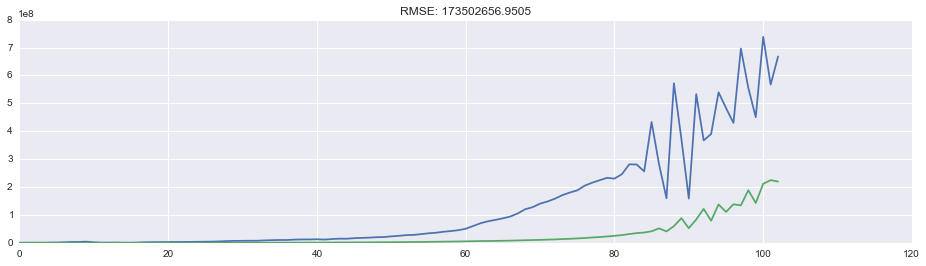

In [33]:
fig = plt.figure(figsize=(16,4))
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(loan_df['Funded_Amnt_Monthly'])
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-loan_df['Funded_Amnt_Monthly'])**2)/len(loan_df)))
loan_df['Prediction_ARIMA'] = predictions_ARIMA

In the above graph, we see that the model equations are predicting the funded amount on the normal variable very pessimistically. This is ok however, as we have a log transformed variable "Funded Amount Monthly". With a slight change to its true value, the exponential grows rapidly and the model would overpredict. Going ahead with this model, we now predict the future "funding requirements"

In [34]:
start = datetime.datetime.strptime("2015-12-01", "%Y-%m-%d")
date_list = [start + relativedelta(months=x) for x in range(0,24)]
future = pd.DataFrame(index=date_list, columns= loan_df.columns)
loan_df = pd.concat([loan_df, future])

Finally we predict the amount of funds needed in the next 24 months and plot the results.

In [35]:
loan_df['forecast_final_log'] = results_AR.predict(start = loan_df_shape_old, end = loan_df.shape[0], dynamic= True)
loan_df['forecast_final_cumsum'] = loan_df['forecast_final_log'].cumsum()
loan_df['forecast_final_Running_cumsum'] = predictions_ARIMA_log.ix[-1] + loan_df['forecast_final_log'].cumsum()
loan_df['forecast_final'] = np.exp(loan_df['forecast_final_Running_cumsum'])

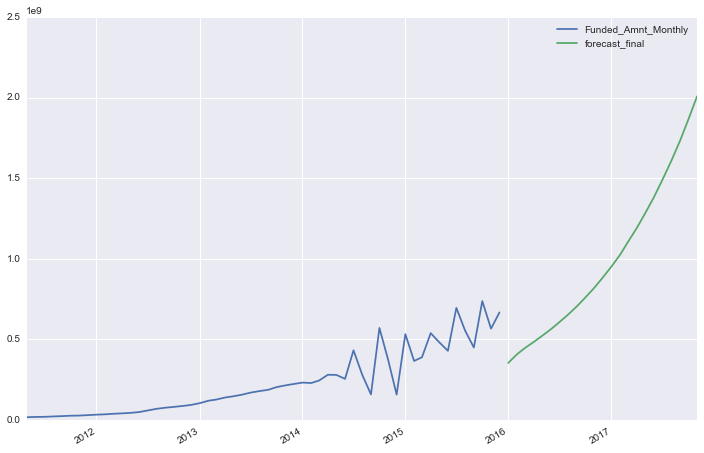

In [36]:
loan_df[['Funded_Amnt_Monthly', 'forecast_final']].ix[-80:].plot(figsize=(12, 8))

As we note in the above graph, the exponential trend in the original series makes accuracy of the final prediction a very difficult task. Even if we go with this result (which starts from lower values than are currently in place, but rises exponentially), we can easily see that the company will need a lot of money very soon, in order to grow at a similar rate.

#### Concluding Remarks on the Forecasting:

In order for the company to survive and grow further, there are many challenges that need to be addressed.

1. The Incoming Payments have reduced. This is an alarming sign and the company should put every effort to build a system to predict and proactively preempt the defaulters or late payers.
2. In order for company to grow at the same rate they have been, they will have to generate cash mroe efficiently and collect the payments at a much faster rate
3. As more loans are issued recently, the amount received should start increasing in next few month. That is very important for the company to survive and grow.
4. At this rate the company would need cash flow of ~2B USD by 2017 from Banks, Payments received and Investors on monthly basis

### Additional Analysis: Are there better parameter or variable choices?

As suggested by the Batch SVM previously, it looks like there might be better parameter set that can help us generage the best Bias-variance trade-off. In this section, we want to see if we can improve the overall accuracy of our model by adjusting the parameters we pass into our Logistic Regression and SVM models and by reducing the number of variables we look at with our model. Either of these changes could lead to better performance in both accuracy and the confusion mattrices.

Overfitting is a common problem in machine learning, where a model performs well on training data but does not generalize well to unseen data (test data). If a model suffers from overfitting, we also say that the model has a high variance, which can be caused by having too many parameters that lead to a model that is too complex given the underlying data. Similarly, our model can also suffer from underfitting (high bias), which means that our model is not complex enough to capture the pattern in the training data well and therefore also suffers from low performance
on unseen data. There are various parameters for finding a good bias-variance tradeoff and to tune the complexity of the model via regularization. 

Cost Function 'C' : A large C gives you low bias and high variance. Low bias because you penalize the cost of missclasification a lot. A small C gives you higher bias and lower variance. A lower C means higher regularization. A lower C thus prevents overfitting.

L1/L2 Regularization : L2 regularization (sometimes also called L2 shrinkage or weight decay) or L1 regularization where penalty is the sum of the absolute weight coefficients while in L2 that term is quadratic)

Below we will try to change the model parameters and try find the optimal values for these parameters.

Please note that both SVC and LinearSVC have the regularization hyperparameter C, but the SGDClassifier has the regularization hyperparameter alpha. Where C = n_samples / alpha